In [3]:
%matplotlib inline


数据加载和处理教程 
====================================


解决任何机器学习问题都需要花很大力气来准备数据。PyTorch提供了很多工具来帮助我们更容易的
加载数据，并且使得我们的代码更加可读。这个教程里，我们会学习怎么加载和预处理数据。

为了运行本教程，我们需要安装如下包：

-  ``scikit-image``: 用于读取图片和进行变换
-  ``pandas``: 处理csv文件

我们可以使用pip安装：

pip install scikit-image pandas




In [4]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

去[这里](https://media.githubusercontent.com/media/fancyerii/fancyerii.github.io/master/assets/faces.zip)下载数据，然后解压到../data目录下。


In [5]:
landmarks_frame = pd.read_csv('../data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


下面我们写一个函数来展示图片以及关键点




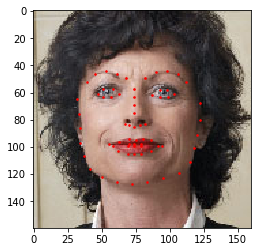

In [6]:
def show_landmarks(image, landmarks): 
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)   
plt.figure()
show_landmarks(io.imread(os.path.join('../data/faces/', img_name)),
               landmarks)
plt.show()

Dataset类
-------------

``torch.utils.data.Dataset``是用于表示dataset的抽象类。我们自定义的dataset应该基础它并且
重写如下方法：


-  ``__len__`` 当调用``len(dataset)``是需要返回dataset的大小
-  ``__getitem__`` 当调用``dataset[i]``时会调用这个函数，我们需要返回第$i$个样本

让我们来创建一个dataset类来处理人脸关键点的数据集。我们会在``__init__``读取csv文件，但是图片
的读取会放到``__getitem__``里实现。这样会更加高效，因为把所有的图片都放到内存里会消耗大量内存空间。

我们的dataset的一个样本是一个dict``{'image': image, 'landmarks': landmarks}``。这个类的构造
函数可以传入一个可选的``transform``参数，它会根据这个参数对图像进行预处理。




In [7]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        参数:
            csv_file (string): 标注关键点的csv文件。
            root_dir (string): 图片所在目录
            transform (callable, optional): 可选的transform，用于处理图像。
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

下面我们来构造这个类的示例，然后显示前4个样本。




0 (324, 215, 3) (68, 2)


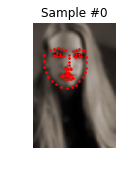

1 (500, 333, 3) (68, 2)


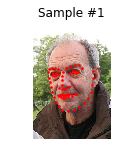

2 (250, 258, 3) (68, 2)


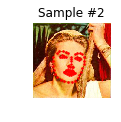

3 (434, 290, 3) (68, 2)


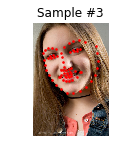

In [8]:
face_dataset = FaceLandmarksDataset(csv_file='../data/faces/face_landmarks.csv',
                                    root_dir='../data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Transforms
----------

上面我们会发现一个问题：图片的大小是不一样的。但是神经网络通常要求输入的大小是固定的，因此我们需要进行一些预处理。

我们下面来创建3个transform:

-  ``Rescale``: 缩放图像成统一的大小
-  ``RandomCrop``: 随机的crop图像，这是一种数据增强的方法。
-  ``ToTensor``: 从numpy转成torch tensor

我们会把它写成一个callable的类，而不是一个函数。这样的好处是调用的时候不要每次都传递参数了。
为了实现这一点，我们需要写一个类，实现一个``__call__``方法。我们使用这个类的代码类似：

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

我们用参数params构造好一个Transform对象之后，再对一个样本进行处理的时候就不要再传递参数了。





In [9]:
class Rescale(object):
    """缩放图像到固定的尺寸

    参数:
        输出的大小(tuple或者int): 缩放后的大小，如果是tuple，那么按照这个参数缩放。如果是int，那么会保持
        宽高比的缩放。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # 图像缩放后，关键点也要相应的比例变化。
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """随机的Crop
    
    参数:
        输出大小 (tuple或者int): 输出的大小。如果是int，那么输出一个正方形
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """把numpy的ndarrays变成Tensors"""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

组合transform
~~~~~~~~~~~~~~~~~~

现在我们需要把多个transform组合起来。

我们首先把图像(宽高中较小的那个)缩放到256，然后随机的crop得到224x224，最后变成PyTorch要求的Channel在前的Tensor。




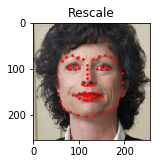

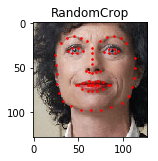

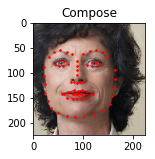

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

遍历dataset
-----------------------------

现在我们把所有的代码用来创建一个dataset，每当需要一个样本的时候，会做如下操作：

-  从文件里读取图片 
-  对图片进行缩放、随机crop和转换成PyTorch的Tensor 
-  因为第二步是随机的，因此实现了数据增强。


接下来我们使用简单的for循环来遍历这个dataset。




In [11]:
transformed_dataset = FaceLandmarksDataset(csv_file='../data/faces/face_landmarks.csv',
                                           root_dir='../data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


但是简单的for循环缺少如下特性：

-  把数据变成minibatch
-  随机打散数据
-  并发的进行数据处理

``torch.utils.data.DataLoader``是一个提供了上面特性的一个迭代器。它有一个参数``collate_fn``，
通过这个参数我们可以精确的控制怎么batch数据。不过通常我们使用默认值就可以了。





0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


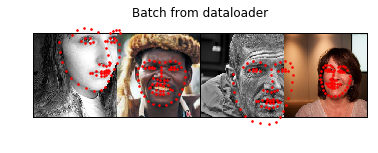

In [12]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# 显示一个batch数据的帮助函数
def show_landmarks_batch(sample_batched): 
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # 只显示前4张图片
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

使用torchvision
----------------------

在这个教程里，我们自己实现了dataset类和transform里。``torchvision``包提供了常见的dataset和transform。
因此我们通常不需要自己来实现。一个非常通用的dataset是torchvision里的``ImageFolder``。
它假设目录结构如下所示：

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

根目录下的第一级子目录是类名，然后下面是这个类的图片。

类似的也提供了对``PIL.Image``常见的Transform，比如``RandomHorizontalFlip``, ``Scale``。因此，
为了实现我们上面自己实现的数据加载和预处理，我们也可以用下面的代码来实现相同的效果：
  import torch
  from torchvision import transforms, datasets

  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
  hymenoptera_dataset = datasets.ImageFolder(root='../data/hymenoptera_data/train',
                                             transform=data_transform)
  dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)


